In [1]:
import numpy as np
from skimage import io
from veg_index import Image_Multi
import matplotlib.pyplot as plt
from matplotlib import path
import matplotlib.patches as patches
import georasters as gr

from scipy import misc
import math
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
import Utils
import cv2

/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


# Load Image and Transform Polygon to rectangle

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[(6, 1806), (3540, 3535), (4406, 1706), (506, 6)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Matrix Transform: 
 [[ 1.09359865e+00  3.03777403e-01 -5.55183581e+02]
 [-4.12426621e-01  9.46155189e-01  2.03010939e+02]
 [ 4.02437136e-05 -3.12562311e-05  1.00000000e+00]]
Dimension of Points matrix as input to Persepective transform 
(1, 4, 2)
Dimension of Points matrix as input to Persepective transform 
(1, 1, 2)
Transform Points of Polygon 
[[[-1.1143848e-13 -2.7859620e-14]
  [ 4.2540000e+03  2.5286429e-14]
  [ 4.2540000e+03  2.0230000e+03]
  [ 0.0000000e+00  2.0230000e+03]]]
Inverse Transform of point (0,0)
[[[506.   6.]]]


<Figure size 432x288 with 0 Axes>

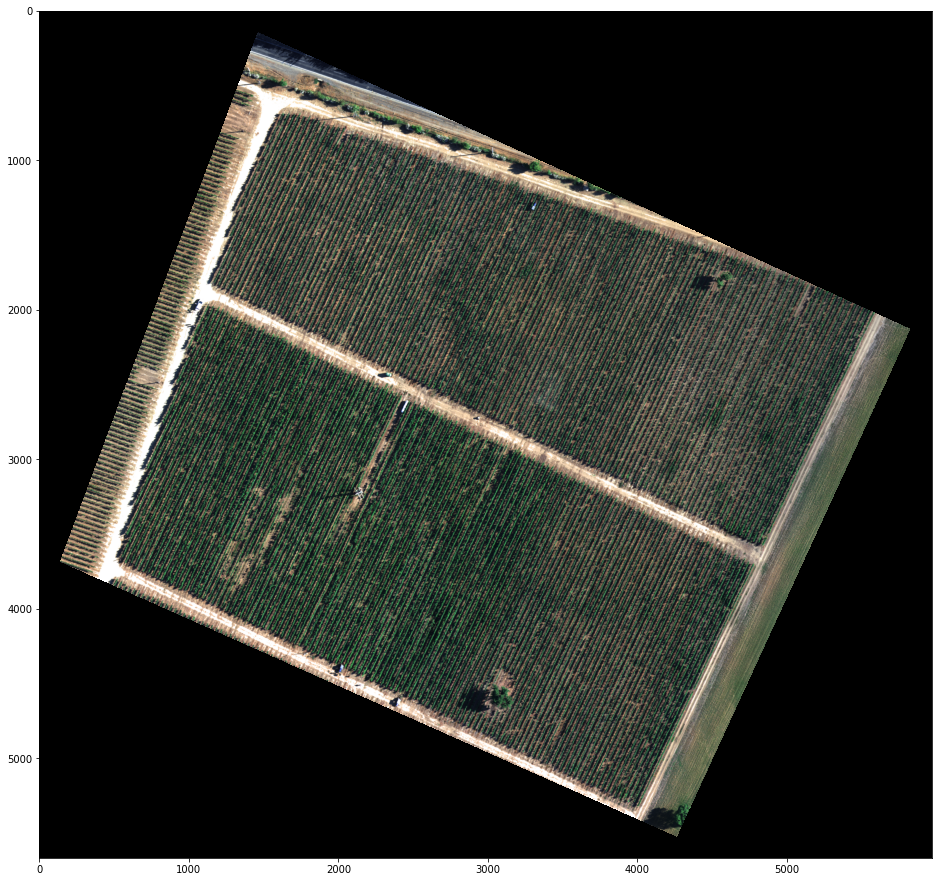

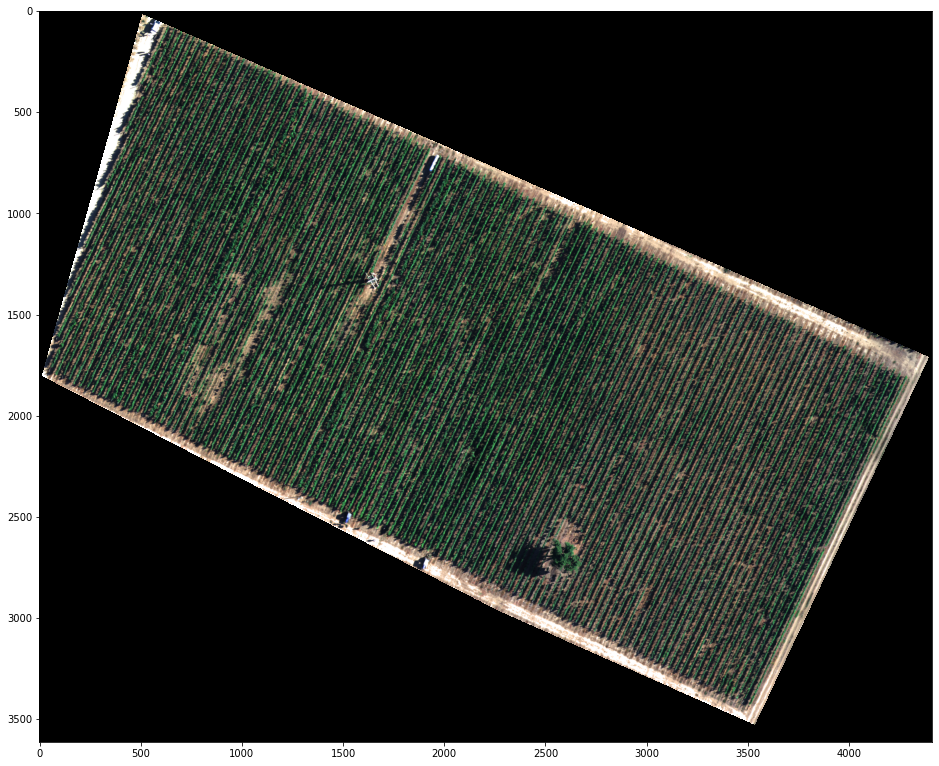

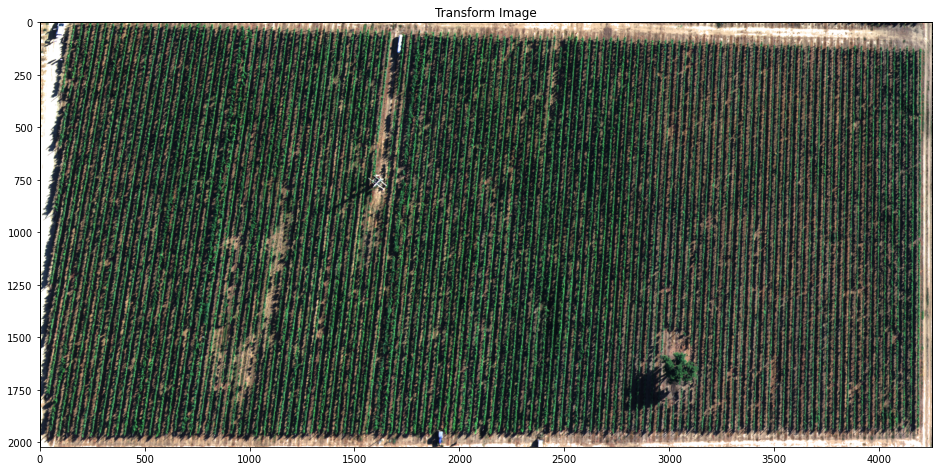

In [2]:
im_red_path = "Barrack A/result_Red.tif"
im_green_path = "Barrack A//result_Green.tif"
im_blue_path = "Barrack A/result_Blue.tif"
im_nir_path = "Barrack A/result_NIR.tif"
im_rededge_path = "Barrack A/result_RedEdge.tif"

im_multi = Image_Multi(im_red_path, im_green_path, im_blue_path, im_nir_path, im_rededge_path)

#List_P = [(1600, 500),(4800, 3600), (1100, 1900), (5500, 1900)]
List_P = [(500, 3700), (1000, 1900), (4900, 3600), (4000, 5500)]
np.rot90(List_P)

im_multi_seg = im_multi.Segmentation(List_P)

plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow(im_multi.RGB().raster)

plt.figure(1)
plt.figure(figsize=(16, 16))
plt.imshow(im_multi_seg.RGB().raster)
print(im_multi_seg.list_P)

Points = np.array(im_multi_seg.list_P)
Points_order = Utils.order_points_rect(Points)

M, maxWidth, maxHeight = Utils.perspectiveTransform(Points)

warped = cv2.warpPerspective(im_multi_seg.RGB().raster, M, (maxWidth, maxHeight))

plt.figure(2)
plt.figure(figsize=(16, 16))
plt.imshow(warped)
plt.title('Transform Image')
print("Matrix Transform: \n " + str(M))
print("Dimension of Points matrix as input to Persepective transform \n" + str((np.array([Points_order])).shape))
print("Dimension of Points matrix as input to Persepective transform \n" + str((np.array([[[0,0]]])).shape))
print("Transform Points of Polygon \n" + str(cv2.perspectiveTransform(np.expand_dims(Points_order, axis = 0), M)))
print("Inverse Transform of point (0,0)\n" + str(cv2.perspectiveTransform(np.expand_dims([[0.,0.]], axis = 0), np.linalg.inv(M))))

# Subidivision rectangel/polygon

20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


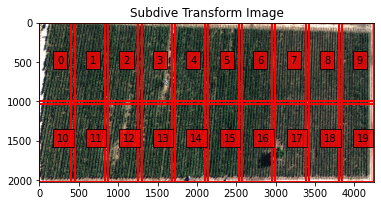

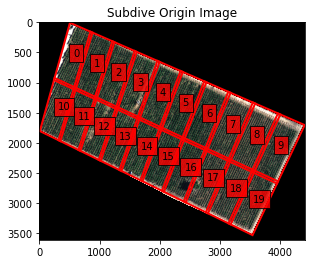

In [3]:
# top-left, top-right, bottom-right, and bottom-left
split_Weight, split_Height = 10, 2
sub_division = Utils.subdivision_rect([split_Weight, split_Height], maxWidth, maxHeight, 20)

print(len(sub_division))

plt.figure(0)
plt.imshow(warped)
plt.title('Subdive Transform Image')
ax = plt.gca()

for i,Poly in enumerate(sub_division):
    poly = patches.Polygon(Poly,
                     linewidth=2,
                     edgecolor='red',
                     fill = False)
    plt.text(np.mean([x[0]  for x in sub_division[i]]), np.mean([y[1]  for y in sub_division[i]]) , str(i),  bbox=dict(facecolor='red', alpha=0.8))

    ax.add_patch(poly)

############## Subidive in Origin Image ################

sub_division_origin = cv2.perspectiveTransform(np.array(sub_division), np.linalg.inv(M))


plt.figure(1)
plt.imshow(im_multi_seg.RGB().raster)
plt.title('Subdive Origin Image')
ax = plt.gca()

for i,Poly in enumerate(sub_division_origin):
    poly = patches.Polygon(Poly,
                     linewidth=2,
                     edgecolor='red',
                     fill = False)
    plt.text(np.mean([x[0]  for x in Poly]), np.mean([y[1]  for y in Poly]) , str(i),  bbox=dict(facecolor='red', alpha=0.8))

    ax.add_patch(poly)

In [4]:
#for i,im in enumerate([im_multi_seg.Segmentation(List_P) for List_P in np.uint(sub_division_origin)]):
 #   plt.figure(i)
  #  plt.imshow(im.RGB().raster)

[[ 506    6]
 [ 880  169]
 [ 598 1124]
 [ 241  958]]
[[ 363 1125]
 [ 645  169]
 [ 271    6]
 [   6  958]]
0.4666666666666667


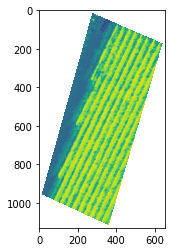

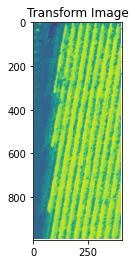

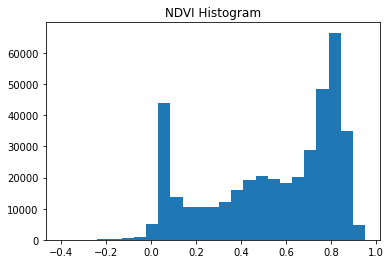

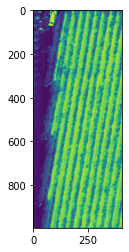

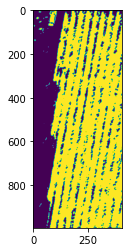

In [5]:
List_P = np.uint(sub_division_origin)
P = List_P[0]
im = im_multi_seg.Segmentation(P) 
NDVI = im.NDVI().raster

#NDVI = 2. * (NDVI - np.nanmin(NDVI)) / (np.nanmax(NDVI) - np.nanmin(NDVI))- 1
#blur[np.isnan(blur)] = 0
Points = np.array(im.list_P)
M, maxWidth, maxHeight = Utils.perspectiveTransform(Utils.order_points_rect(Points))

warped = cv2.warpPerspective(NDVI, M, (maxWidth, maxHeight))

plt.figure(0)
plt.imshow(NDVI)

plt.figure(1)
plt.imshow(warped)
plt.title('Transform Image')

plt.figure(2)
warped[np.isnan(warped)] = 0
plt.hist(warped[~np.isnan(warped)], bins = 25)
plt.title('NDVI Histogram')

blur = cv2.GaussianBlur(warped * 255,(5,5),0).astype('uint8')
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#ret3,th3 = ret1,th1 = cv2.threshold(blur,127,255,cv2.THRESH_BINARY)
plt.figure(3)
plt.imshow(blur)
plt.figure(4)
plt.imshow(th3)
print(P)
print(Points)
print(ret3/255)


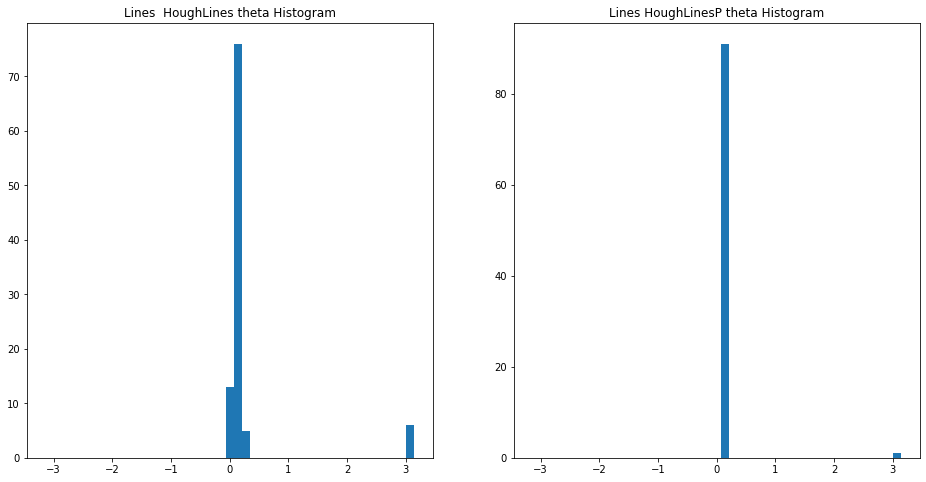

In [6]:
skel_filter = Utils.skeleton(th3, n_important = 100)
angle_resolution = 720
n_important = 100
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / angle_resolution  # angular resolution in radians of the Hough grid
threshold = 100  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 200  # minimum number of pixels making up a line
max_line_gap = 50  # maximum gap in pixels between connectable line segments

lines = cv2.HoughLines(np.uint8(skel_filter),rho, theta, threshold)
lines_P = cv2.HoughLinesP(np.uint8(skel_filter),rho, theta, threshold, np.array([]) ,min_line_length, max_line_gap)

theta_P = [np.pi/2 + np.arctan2(line[0][3] - line[0][1],line[0][2]-line[0][0])  for line in lines_P[:n_important]]


from scipy import signal


theta = lines[0:n_important,0,1]

h = np.histogram(np.array(theta), bins = angle_resolution, range=(-np.pi,np.pi))
peaks = signal.find_peaks_cwt(h[0], widths= np.arange(2,4))

h_P = np.histogram(np.array(theta_P), bins = angle_resolution, range=(-np.pi,np.pi))
peaks_P = signal.find_peaks_cwt(h_P[0], widths= np.arange(2,4))

fig, axs = plt.subplots(1, 2, figsize=(16,8))
axs[0].hist(lines[0:n_important,0,1], bins = 45, range=[-np.pi,np.pi])
axs[0].title.set_text('Lines  HoughLines theta Histogram')


axs[1].hist(theta_P, bins = 45, range=[-np.pi,np.pi])
axs[1].title.set_text('Lines HoughLinesP theta Histogram')

In [7]:
peaks_P
#mesh = np.array(np.meshgrid(h[1][peaks], h_P[1][peaks_P]))

array([379])

Theta in HoughLines:  [0.16580628 3.0455995  3.1154127 ]
Theta in HoughLinesP:  [0.16580628]
combinations:  [[0.16580628 0.16580628]
 [3.04559946 0.16580628]
 [3.11541271 0.16580628]]
Theta prop:  0.16580627876292442


<Figure size 432x288 with 0 Axes>

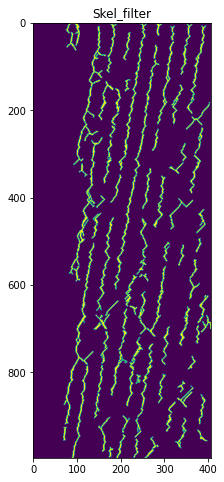

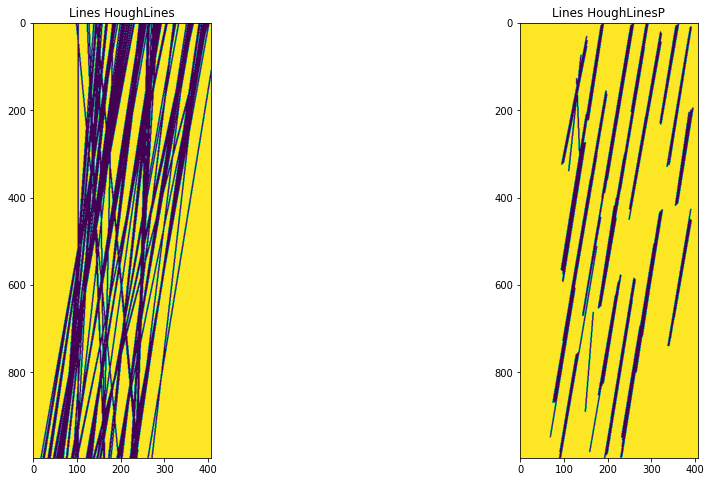

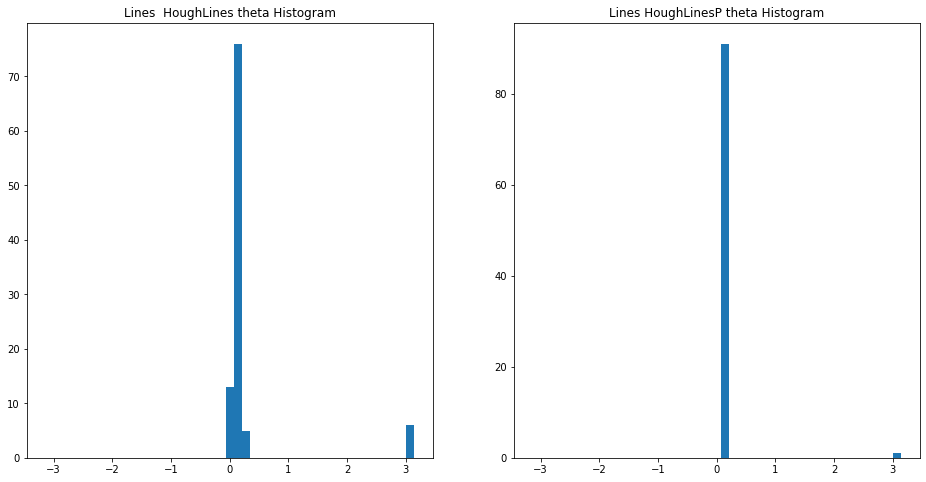

In [8]:
from scipy import ndimage
from scipy.signal import argrelextrema

n_important = 100
skel_filter = Utils.skeleton(th3, n_important = 100)

theta_prop = Utils.angle_lines(skel_filter,  n_important = 100, angle_resolution = 720,
                               threshold = 100, min_line_length = 200, max_line_gap = 50, plot = True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Transform Image new')

<Figure size 432x288 with 0 Axes>

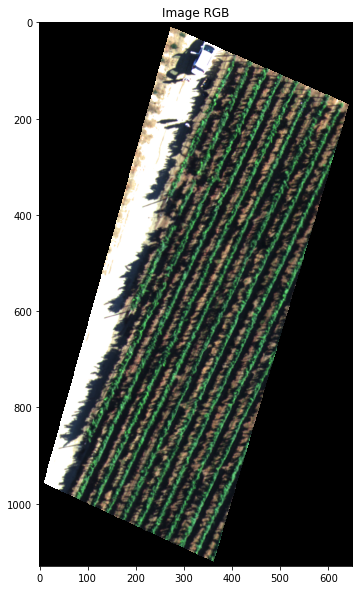

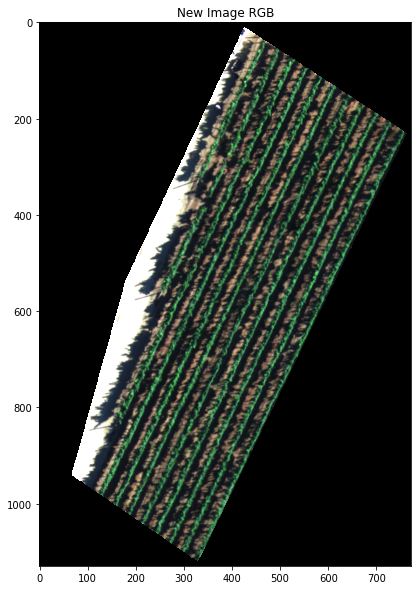

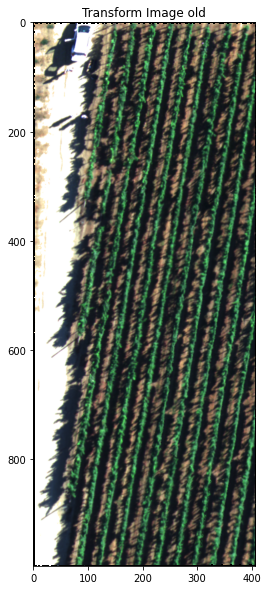

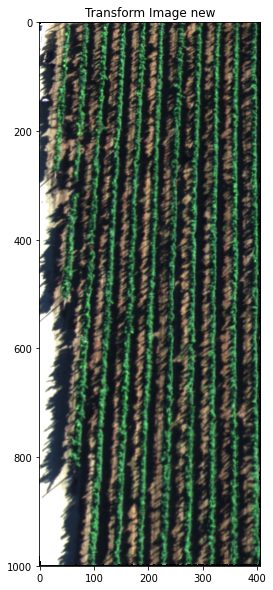

In [9]:
#center = (np.mean([point[0] for point in im.list_P]), np.mean([point[1] for point in im.list_P]))
center = ( im.list_P[0][0], im.list_P[0][1])
matrix = cv2.getRotationMatrix2D( center=center, angle= -theta_prop*180/np.pi, scale=1)

new_P = cv2.transform(np.array([P]), matrix)[0]

im_multi_seg_new = im_multi_seg.Segmentation(new_P)

new_Points = np.array(im_multi_seg_new.list_P)

new_M, new_maxWidth, new_maxHeight = Utils.perspectiveTransform(Utils.order_points_rect(new_Points))




plt.figure(0)
plt.figure(figsize=(10, 10))
plt.imshow(im.RGB().raster)
plt.title( 'Image RGB')

plt.figure(1)
plt.figure(figsize=(10, 10))
plt.imshow(im_multi_seg_new.RGB().raster)
plt.title('New Image RGB')

Points = np.array(im.list_P)

M, maxWidth, maxHeight = Utils.perspectiveTransform(Points)

warped = cv2.warpPerspective(im.RGB().raster, M, (maxWidth, maxHeight))

plt.figure(2)
plt.figure(figsize=(10, 10))
plt.imshow(warped)
plt.title('Transform Image old')



warped = cv2.warpPerspective(im_multi_seg_new.RGB().raster, new_M, (new_maxWidth, new_maxHeight))

plt.figure(3)
plt.figure(figsize=(10, 10))
plt.imshow(warped)
plt.title('Transform Image new')

Theta in HoughLines:  [0.03490658 2.7925267  3.106686  ]
Theta in HoughLinesP:  [0.03490659]
combinations:  [[0.03490658 0.03490659]
 [2.79252672 0.03490659]
 [3.10668612 0.03490659]]
Theta prop:  0.03490658490468701


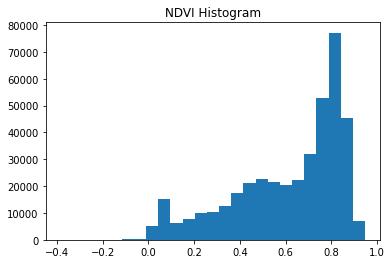

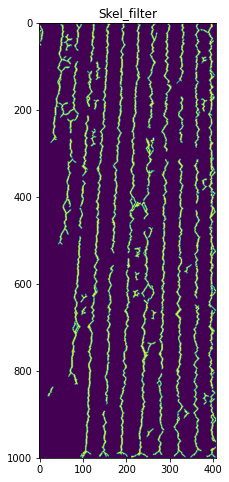

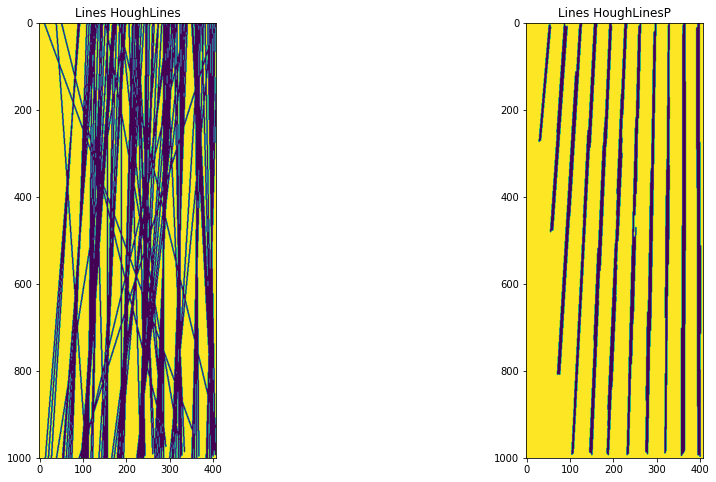

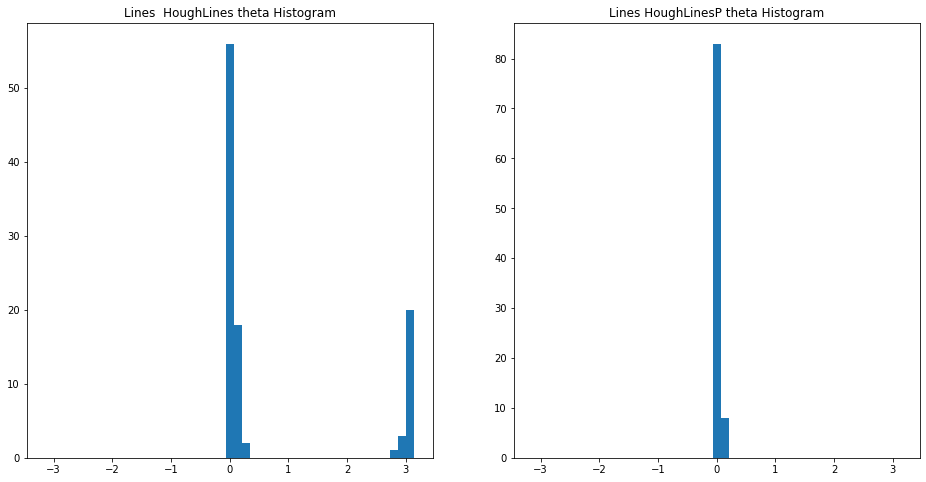

In [10]:

warped = cv2.warpPerspective(im_multi_seg_new.NDVI().raster, new_M, (new_maxWidth, new_maxHeight))
plt.figure(0)
warped[np.isnan(warped)] = 0
plt.hist(warped[~np.isnan(warped)], bins = 25)
plt.title('NDVI Histogram')

blur = cv2.GaussianBlur(warped * 255,(5,5),0).astype('uint8')
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

n_important = 100
skel_filter = Utils.skeleton(th3, n_important = 100)

theta_prop = Utils.angle_lines(skel_filter,  n_important = 100, threshold = 100, min_line_length = 200, max_line_gap = 50, plot = True)




# All previus example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Old Points:  [[ 506    6]
 [ 880  169]
 [ 598 1124]
 [ 241  958]]
New Points:  [[ 689   45]
 [1031  267]
 [ 595 1163]
 [ 270  940]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Transform Image')

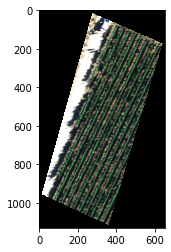

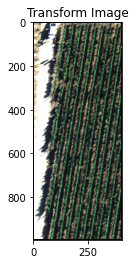

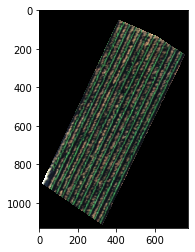

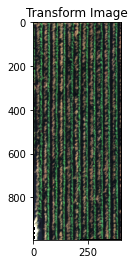

In [35]:
P = List_P[0]
im = im_multi_seg.Segmentation(P) 
NDVI = im.NDVI().raster
#new_P = Utils.

#NDVI = 2. * (NDVI - np.nanmin(NDVI)) / (np.nanmax(NDVI) - np.nanmin(NDVI))- 1
#blur[np.isnan(blur)] = 0
Points = np.array(im.list_P)
Points_order = Utils.order_points_rect(Points)

M, maxWidth, maxHeight = Utils.perspectiveTransform(Points_order)

warped = cv2.warpPerspective(NDVI, M, (maxWidth, maxHeight))
warped[np.isnan(warped)] = 0

# Otsu
blur = cv2.GaussianBlur(warped * 255,(5,5),0).astype('uint8')
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

n_important = 100
skel_filter = Utils.skeleton(th3, n_important = 100)

theta_prop = Utils.angle_lines(skel_filter,  n_important = 100, angle_resolution = 720,
                               threshold = 100, min_line_length = 200,
                               max_line_gap = 50, plot = False)


#center = (np.mean([point[0] for point in im.list_P]), np.mean([point[1] for point in im.list_P]))
center = ( im.list_P[0][0], im.list_P[0][1])
matrix = cv2.getRotationMatrix2D(center=center, angle= -theta_prop*180/np.pi, scale=1)

new_P = cv2.transform(np.array([P]), matrix)[0]

im_multi_seg_new = im_multi_seg.Segmentation(new_P)

new_Points = np.array(im_multi_seg_new.list_P)

new_M, new_maxWidth, new_maxHeight = Utils.perspectiveTransform(Utils.order_points_rect(new_Points))

print('Old Points: ', P)
print('New Points: ', new_P)

plt.figure(0)
plt.imshow(im.RGB().raster)

plt.figure(1)
plt.imshow(cv2.warpPerspective(im.RGB().raster, M, (maxWidth, maxHeight)))
plt.title('Transform Image')

plt.figure(2)
plt.imshow(im_multi_seg_new.RGB().raster)

plt.figure(3)
plt.imshow(cv2.warpPerspective(im_multi_seg_new.RGB().raster, new_M, (new_maxWidth, new_maxHeight)))
plt.title('Transform Image')

0.16580627876292442
0.1483529835166133
0.13962633961874804
0.11344640047457144
0.10471975657670618
0.08726646133039484
0.06108652404886361
0.05235987828835298
0.030543261774701236
0.01308996932235762
0.16580627876292442
0.15271631173507338
0.13962633961874804
0.122173048097727
0.10471975657670618
0.08726646133039484
0.06981316980937402
0.047996555158367205
0.03490658490468701
0.01308996932235762


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


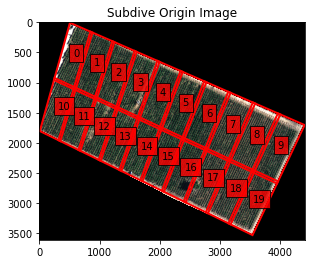

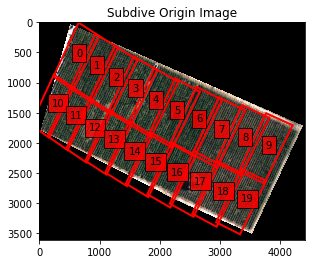

In [59]:
List_P = np.uint(sub_division_origin)
List_new_P = []

for P in List_P:
    #P = List_P[3]
    im = im_multi_seg.Segmentation(P) 
    NDVI = im.NDVI().raster

    #NDVI = 2. * (NDVI - np.nanmin(NDVI)) / (np.nanmax(NDVI) - np.nanmin(NDVI))- 1
    #blur[np.isnan(blur)] = 0
    Points = np.array(im.list_P)

    M, maxWidth, maxHeight = Utils.perspectiveTransform(Utils.order_points_rect(Points))

    warped = cv2.warpPerspective(NDVI, M, (maxWidth, maxHeight))
    warped[np.isnan(warped)] = 0

    # Otsu
    blur = cv2.GaussianBlur(warped * 255,(5,5),0).astype('uint8')
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    n_important = 100
    skel_filter = Utils.skeleton(th3, n_important = 100)

    theta_prop = Utils.angle_lines(skel_filter,  n_important = 100, angle_resolution = 720,
                                   threshold = 100, min_line_length = 200,
                                   max_line_gap = 50, plot = False)


    center_pol = (np.mean([point[0] for point in im.list_P]), np.mean([point[1] for point in im.list_P]))
    center = (im.list_P[0][0], im.list_P[0][1])
    matrix = cv2.getRotationMatrix2D(center=center, angle= -theta_prop*180/np.pi, scale=1)
    
    (h, w) = (maxHeight, maxWidth)
    cos = np.abs(matrix[0, 0])
    sin = np.abs(matrix[0, 1])
     #compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
     #adjust the rotation matrix to take into account translation
    matrix[0, 2] += (nW / 2) - center_pol[0]
    matrix[1, 2] += (nH / 2) - center_pol[1]
    
    new_P = cv2.transform(np.array([P]), matrix)[0]

    #im_multi_seg_new = im_multi_seg.Segmentation(new_P)

    #new_Points = np.array(im_multi_seg_new.list_P)
    List_new_P.append(new_P)
    print(theta_prop)
    
plt.figure(0)
plt.imshow(im_multi_seg.RGB().raster)
plt.title('Subdive Origin Image')
ax = plt.gca()

for i,Poly in enumerate(List_P):
    poly = patches.Polygon(Poly,
                     linewidth=2,
                     edgecolor='red',
                     fill = False)
    plt.text(np.mean([x[0]  for x in Poly]), np.mean([y[1]  for y in Poly]) , str(i),  bbox=dict(facecolor='red', alpha=0.8))

    ax.add_patch(poly)
    
    
plt.figure(1)
plt.imshow(im_multi_seg.RGB().raster)
plt.title('Subdive Origin Image')
ax = plt.gca()

for i,Poly in enumerate(List_new_P):
    poly = patches.Polygon(Poly,
                     linewidth=2,
                     edgecolor='red',
                     fill = False)
    plt.text(np.mean([x[0]  for x in Poly]), np.mean([y[1]  for y in Poly]) , str(i),  bbox=dict(facecolor='red', alpha=0.8))

    ax.add_patch(poly)

In [58]:
n = 3
print((np.mean([point[0] for point in List_P[n]]), np.mean([point[1] for point in List_P[n]])),
    (np.mean([point[0] for point in List_new_P[n]]), np.mean([point[1] for point in List_new_P[n]])))
print(List_P[n],
    List_new_P[n])

(1624.25, 1044.25) (1544.5, 1137.75)
[[1580  474]
 [1994  654]
 [1658 1616]
 [1265 1433]] [[1565  566]
 [1956  792]
 [1513 1710]
 [1144 1483]]


(904.0, 756.25)

array([[ 846,  154],
       [1244,  327],
       [ 945, 1285],
       [ 565, 1109]], dtype=uint64)

array([[ 934,  190],
       [1302,  419],
       [ 865, 1323],
       [ 515, 1093]], dtype=int32)